# News Article Summarization with Encoder-Decoder Model

Florian Frick

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from transformers import BartTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
# inspired by https://medium.com/@bavalpreetsinghh/transformer-from-scratch-using-pytorch-28a5d1b2e033
class PositionalEmbedding(nn.Module):
    def __init__(self, emb_dim, max_seq_length):
        super().__init__()
        # Create fixed sinusoidal positional embeddings
        pe = torch.zeros(max_seq_length, emb_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term) # even-index columns
        pe[:, 1::2] = torch.cos(position * div_term) # odd-index columns
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.shape[1], :]  # Adjust to match the input size
        
        return x

In [3]:
class AttentionHead(nn.Module):
  def __init__(self, emb_dim, head_size, causal=False):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(emb_dim, head_size, bias=False)
    self.key = nn.Linear(emb_dim, head_size, bias=False)
    self.value = nn.Linear(emb_dim, head_size, bias=False)

    self.causal = causal

  def forward(self, x, kv=None, k_mask=None):
    B, T, C = x.shape
    Q = self.query(x)                            # Shape: (B, q_len, head_size)
    K = self.key(kv if kv is not None else x)    # Shape: (B, seq_len, head_size) where seq_len = k_len if cross attention, else q_len
    V = self.value(kv if kv is not None else x)  # Shape: (B, seq_len, head_size) where seq_len = k_len if cross attention, else q_len

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1) # Shape: (B, q_len, k_len)

    # Scaling to prevent softmax saturation
    attention = attention / (self.head_size ** 0.5)
    
    # Applying k padding mask if provided (column-wise mask)
    if k_mask is not None:
      k_mask = k_mask.unsqueeze(1) # Shape: (B, 1, k_len) can be broadcast with attention
      attention = attention.masked_fill(k_mask == 0, float("-inf"))

    # Applying causal mask for decoder's masked MHA
    if self.causal:
      c_mask = torch.tril(torch.ones(T, T, device=x.device)) # is broadcastable with attention (B, T, T)
      attention = attention.masked_fill(c_mask == 0, float("-inf"))

    attention = torch.softmax(attention, dim=-1)

    # Weighted sum of values
    output = attention @ V # Shape: (B, seq_len, head_size)  where seq_len = k_len if cross attention, else q_len

    return output

In [4]:
class MultiHeadAttention(nn.Module):
  def __init__(self, emb_dim, n_heads, causal=False):
    super().__init__()
    
    assert emb_dim % n_heads == 0, "emb_dim must be divisible by n_heads"
    
    self.head_size = emb_dim // n_heads

    self.W_o = nn.Linear(emb_dim, emb_dim, bias=False)

    self.causal = causal

    self.heads = nn.ModuleList([AttentionHead(emb_dim, self.head_size, causal=self.causal) for _ in range(n_heads)])

  def forward(self, x, kv=None, k_mask=None):
    # Combine attention heads
    out = torch.cat([head(x, kv, k_mask=k_mask) for head in self.heads], dim=-1)
    
    out = self.W_o(out)

    return out

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim, n_heads, r_mlp=4, dropout=0.1):
        super().__init__()
        self.emb_dim = emb_dim
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(emb_dim)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(emb_dim, n_heads)

        # Dropout after MHA
        self.dropout1 = nn.Dropout(dropout)  

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(emb_dim)

        # Multilayer Perceptron
        self.mlp = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim * r_mlp),
            nn.GELU(),
            nn.Linear(self.emb_dim * r_mlp, self.emb_dim)
        )

        # Dropout after MLP
        self.dropout2 = nn.Dropout(dropout)  

    def forward(self, x, src_mask=None):
        # Residual Connection After Sub-Layer 1 (MHA)
        x = x + self.dropout1(self.mha(self.ln1(x), k_mask=src_mask))

        # Residual Connection After Sub-Layer 2 (MLP)
        x = x + self.dropout2(self.mlp(self.ln2(x)))

        return x


In [6]:
class TransformerDecoder(nn.Module):
    def __init__(self, emb_dim, n_heads, r_mlp=4, dropout=0.1):
        super().__init__()
        self.emb_dim = emb_dim
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(emb_dim)
        self.masked_mha = MultiHeadAttention(emb_dim, n_heads, causal=True)
        self.dropout1 = nn.Dropout(dropout)  # Dropout after masked MHA

        self.ln2 = nn.LayerNorm(emb_dim)
        self.cross_attention = MultiHeadAttention(emb_dim, n_heads)
        self.dropout2 = nn.Dropout(dropout)  # Dropout after cross-attention

        self.ln3 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim * r_mlp),
            nn.GELU(),
            nn.Linear(self.emb_dim * r_mlp, self.emb_dim)
        )
        self.dropout3 = nn.Dropout(dropout)  # Dropout after MLP

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        x = x + self.dropout1(self.masked_mha(self.ln1(x), k_mask=tgt_mask))
        x = x + self.dropout2(self.cross_attention(self.ln2(x), kv=encoder_output, k_mask=src_mask))
        x = x + self.dropout3(self.mlp(self.ln3(x)))
        return x

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, max_seq_length, n_heads, n_layers, dropout=0.1):  
        super().__init__()

        self.encoder_embedding = nn.Embedding(vocab_size, emb_dim)
        self.positional_embedding = PositionalEmbedding(emb_dim, max_seq_length)

        self.dropout = nn.Dropout(dropout)

        self.encoder = nn.ModuleList(
            [TransformerEncoder(emb_dim, n_heads, dropout=dropout) for _ in range(n_layers)]
        )

    def forward(self, text, src_mask=None):
        x = self.encoder_embedding(text)
        x = self.positional_embedding(x)
        x = self.dropout(x)

        for encoder_layer in self.encoder:
            x = encoder_layer(x, src_mask=src_mask)

        return x


In [8]:
class TextDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, max_seq_length, n_heads, n_layers, dropout=0.1):
        super().__init__()

        self.decoder_embedding = nn.Embedding(vocab_size, emb_dim)
        self.positional_embedding = PositionalEmbedding(emb_dim, max_seq_length)

        self.dropout = nn.Dropout(dropout)

        self.decoder = nn.ModuleList(
            [TransformerDecoder(emb_dim, n_heads, dropout=dropout) for _ in range(n_layers)]
        )

        self.output_projection = nn.Linear(emb_dim, vocab_size)

    def forward(self, tgt, encoder_outputs, src_mask=None, tgt_mask=None):
        q = self.decoder_embedding(tgt)
        q = self.positional_embedding(q)
        q = self.dropout(q)  # Dropout after embedding

        for decoder_layer in self.decoder:
            q = decoder_layer(q, encoder_outputs, src_mask=src_mask, tgt_mask=tgt_mask)

        q = self.output_projection(q)
        return q


In [9]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, max_text_length, max_summary_length, n_heads, n_layers):
        super().__init__()
        self.encoder = TextEncoder(vocab_size, emb_dim, max_text_length, n_heads, n_layers)
        self.decoder = TextDecoder(vocab_size, emb_dim, max_summary_length, n_heads, n_layers)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        encoder_outputs = self.encoder(src, src_mask=src_mask)
        # print(tokenizer.tokenizer.batch_decode(tgt, skip_special_tokens=False))
        decoder_outputs = self.decoder(tgt, encoder_outputs, src_mask=src_mask, tgt_mask=tgt_mask)
        # print("Decoder Output:", tokenizer.tokenizer.batch_decode(decoder_outputs.argmax(dim=-1), skip_special_tokens=False))
        return decoder_outputs

    def generate(self, src, src_mask=None, max_length=128):
        encoder_outputs = self.encoder(src, src_mask=src_mask) # Shape: (batch_size, seq_len, hidden_dim)

        B = src.size(0)
        # Initialize predicted text with the start token {<s>: 0}
        predicted_text = torch.full((B, 1), fill_value=0, device=src.device) # Shape: (B, 1)
        
        for _ in range(max_length):
            decoder_outputs = self.decoder(predicted_text, encoder_outputs, src_mask=src_mask) # mask encoder outputs corresponding with padding in the input

            # next_token = torch.multinomial(torch.softmax(decoder_outputs[:, -1, :], dim=-1), num_samples=1)  # Sample from the output distribution
            next_token = decoder_outputs[:, -1, :].argmax(dim=-1, keepdim=True)

            predicted_text = torch.cat((predicted_text, next_token), dim=1)

            if torch.all(next_token == 2):  # Stop when all sequences predict <eos>
                break
                    
        return predicted_text

In [10]:
# Bart Tokenizer:
# tokenizer.tokenizer.decode([0,1,2])
# '<s><pad></s>'
class sumTokenizer:
    def __init__(self, max_text_length=512, max_summary_length=128):
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
        self.max_text_length = max_text_length
        self.max_summary_length = max_summary_length
        self.vocab_size = len(self.tokenizer)
        
    def __call__(self, text, is_target=False, padding=True, truncation=True):
        if is_target:
            return self.tokenizer(
                text,
                padding='max_length' if padding else False,
                truncation=truncation,
                max_length=self.max_summary_length,
                return_tensors='pt'
            )
        else:
            return self.tokenizer(
                text,
                padding='max_length' if padding else False,
                truncation=truncation,
                max_length=self.max_text_length,
                return_tensors='pt'
            )
            
    
    def decode(self, token_ids, skip_special_tokens=True):
        return self.tokenizer.decode(token_ids, skip_special_tokens=skip_special_tokens)

In [11]:
class xsumDataset(Dataset):
    def __init__(self, split="train", max_text_length=512, max_summary_length=128):
        self.dataset = load_dataset("EdinburghNLP/xsum")[split]
        self.tokenizer = sumTokenizer(max_text_length, max_summary_length)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        # Get text and summary from dataset
        text = self.dataset[i]["document"]
        summary = self.dataset[i]["summary"]

        # Tokenize input and target
        inputs = self.tokenizer(text, is_target=False)
        targets = self.tokenizer(summary, is_target=True)

        target_ids = targets["input_ids"].squeeze(0)

        # Shift targets right for decoder input
        decoder_input_ids = torch.cat(
            [torch.tensor([1], device=target_ids.device), target_ids[:-1]]  # 1 is the <pad> token
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "input_mask": inputs["attention_mask"].squeeze(0),
            "target_ids": target_ids,  # Used for loss calculation
            "decoder_input_ids": decoder_input_ids,  # Shifted for decoder
            "target_mask": targets["attention_mask"].squeeze(0)
        }


## Demonstrating that the encoder decoder can memorize a single training example.

In [12]:
class DummyDataset(Dataset):
    def __init__(self, max_text_length=20, max_summary_length=10, total_examples=10, unk_text=False):
        self.tokenizer = sumTokenizer(max_text_length, max_summary_length)

        if unk_text:
            self.text = "A new text input unknown to the model."
            self.summary = "unknown input"
        else:
            self.text = "Example input to test whether model can memorize a single example"
            self.summary = "The summary of example input"
        self.total_examples = total_examples

    def __len__(self):
        return self.total_examples
    
    def __getitem__(self, i):
        # Tokenize input and target
        inputs = self.tokenizer(self.text, is_target=False)
        targets = self.tokenizer(self.summary, is_target=True)

        target_ids = targets["input_ids"].squeeze(0)
        
        # Shift targets right: [<s>, The, summary, ..., </s>] -> [<pad>, <s>, The, summary, ...]
        decoder_input_ids = torch.cat(
            [torch.tensor([1], device=target_ids.device), target_ids[:-1]]  # Assuming 1 is the <pad> token
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "input_mask": inputs["attention_mask"].squeeze(0),
            "target_ids": target_ids,  # Used for loss calculation
            "decoder_input_ids": decoder_input_ids,  # Shifted for decoder
            "target_mask": targets["attention_mask"].squeeze(0)
        }

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

emb_dim = 256
max_text_length=20
max_summary_length=10
text_heads = 8
text_layers = 6

epochs = 4
batch_size = 2
lr = 5e-5


train_set = DummyDataset(max_text_length, max_summary_length)
test_set = DummyDataset(max_text_length, max_summary_length, unk_text=True)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Using device:  cuda (NVIDIA GeForce RTX 4060)


In [14]:
# Initialize tokenizer and model
tokenizer = sumTokenizer(max_text_length, max_summary_length)
model = EncoderDecoder(
    vocab_size=tokenizer.vocab_size,
    emb_dim=emb_dim,
    max_text_length=max_text_length,
    max_summary_length=max_summary_length,
    n_heads=text_heads,
    n_layers=text_layers
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        src_mask = batch["input_mask"].to(device)
        target_ids = batch["target_ids"].to(device)  # Unshifted, used for loss
        decoder_input_ids = batch["decoder_input_ids"].to(device)  # Shifted, used for input
        tgt_mask = batch["target_mask"].to(device)

        # Forward pass with shifted decoder input
        outputs = model(
            input_ids,
            decoder_input_ids,  # Use shifted target IDs
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )

        # Compute loss (predicting `target_ids`)
        loss = F.cross_entropy(
            outputs.view(-1, outputs.size(-1)),  
            target_ids.view(-1),                 
            ignore_index=1  # Ensure 1 is actually the <pad> token!
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("Training loss:", loss.item())

Epoch 1/4
Training loss: 11.298800468444824
Training loss: 10.20062255859375
Training loss: 9.440526962280273
Training loss: 8.704160690307617
Training loss: 7.706082820892334
Epoch 2/4
Training loss: 6.863729953765869
Training loss: 6.277052879333496
Training loss: 5.524877071380615
Training loss: 4.868727684020996
Training loss: 4.246597766876221
Epoch 3/4
Training loss: 3.675595998764038
Training loss: 3.1386337280273438
Training loss: 2.612342596054077
Training loss: 1.9886587858200073
Training loss: 1.601847529411316
Epoch 4/4
Training loss: 1.4121911525726318
Training loss: 0.9618296027183533
Training loss: 0.7298752069473267
Training loss: 0.7371541261672974
Training loss: 0.5315788984298706


In [15]:
# Testing the model on a batch from the train loader (known dummy example)
test_batch = next(iter(train_loader))
input_ids = test_batch["input_ids"].to(device)
src_mask = test_batch["input_mask"].to(device)
target_ids = test_batch["target_ids"].to(device)
tgt_mask = test_batch["target_mask"].to(device)

print("Test input:",tokenizer.tokenizer.decode(input_ids[0], skip_special_tokens=False))
print("\nTest target:",tokenizer.tokenizer.decode(target_ids[0], skip_special_tokens=False))

model.eval()
with torch.no_grad():
    outputs = model.generate(input_ids, src_mask=src_mask, max_length=max_summary_length)

predicted_text = tokenizer.tokenizer.batch_decode(outputs, skip_special_tokens=False)  # Decode to text
print("Generated Output:", predicted_text)  # Print the predicted output

Test input: <s>Example input to test whether model can memorize a single example</s><pad><pad><pad><pad><pad><pad>
Test target: <s>The summary of example input</s><pad><pad><pad>
forward: ['The summary of example input</s> of input input input', 'The summary of example input</s> of input input input']
fwd ce loss: tensor(3.6662, device='cuda:0')
Generated Output: ['<s>The summary of example input</s>', '<s>The summary of example input</s>']


In [16]:
# Testing the model on a batch from the test loader (unseen example)
test_batch = next(iter(test_loader))
input_ids = test_batch["input_ids"].to(device)
src_mask = test_batch["input_mask"].to(device)
target_ids = test_batch["target_ids"].to(device)
tgt_mask = test_batch["target_mask"].to(device)

print("Test input:",tokenizer.tokenizer.decode(input_ids[0], skip_special_tokens=False))
print("\nTest target:",tokenizer.tokenizer.decode(target_ids[0], skip_special_tokens=False))

model.eval()
with torch.no_grad():
    outputs = model.generate(input_ids, src_mask=src_mask, max_length=max_summary_length)

predicted_text = tokenizer.tokenizer.batch_decode(outputs, skip_special_tokens=True)  # Decode to text
print("Predicted Output:", predicted_text)  # Print the predicted output

Test input: <s>A new text input unknown to the model.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Test target: <s>unknown input</s><pad><pad><pad><pad><pad><pad>
forward: ['The input</s> of input input input input input input', 'The input</s> of input input input input input input']
fwd ce loss: tensor(6.1182, device='cuda:0')
Predicted Output: ['The summary of example input', 'The summary of example input']


## Training on xsum

In [17]:
emb_dim = 256
max_text_length=512
max_summary_length=128
text_heads = 8
text_layers = 8

epochs = 5
batch_size = 8
lr = 5e-5

In [18]:
train_set = xsumDataset(split="train", max_text_length=max_text_length, max_summary_length=max_summary_length)
val_set = xsumDataset(split="validation", max_text_length=max_text_length, max_summary_length=max_summary_length)
test_set = xsumDataset(split="test", max_text_length=max_text_length, max_summary_length=max_summary_length)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, pin_memory=True)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, pin_memory=True)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Initialize tokenizer and model
tokenizer = sumTokenizer(max_text_length=max_text_length, max_summary_length=max_summary_length)
model = EncoderDecoder(
    vocab_size=tokenizer.vocab_size,
    emb_dim=emb_dim,
    max_text_length=max_text_length,
    max_summary_length=max_summary_length,
    n_heads=text_heads,
    n_layers=text_layers
).to(device)

Using device:  cuda (NVIDIA GeForce RTX 4060)


In [20]:
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

scaler = torch.amp.GradScaler("cuda")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()  # Ensure model is in training mode

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch["input_ids"].to(device)
        src_mask = batch["input_mask"].to(device)
        target_ids = batch["target_ids"].to(device)  # Unshifted, used for loss
        decoder_input_ids = batch["decoder_input_ids"].to(device)  # Shifted, used for input
        tgt_mask = batch["target_mask"].to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass with shifted decoder input
        with torch.amp.autocast("cuda"):
            outputs = model(
                input_ids,
                decoder_input_ids,  # Use shifted targets as decoder input
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )

            # Calculate cross entropy loss (predicting `target_ids`)
            loss = F.cross_entropy(
                outputs.view(-1, outputs.size(-1)),  # [B*summary_len, vocab_size]
                target_ids.view(-1),                 # [B*summary_len]
                ignore_index=1                       # Ignore padding tokens
            )

        loss_history.append(loss.item())

        # Backward pass with scaler for FP16 training
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Every 50 batches, print average loss and save model
        if (batch_idx + 1) % 50 == 0:
            avg_loss = np.mean(loss_history[-50:])
            progress_bar.set_postfix(loss=avg_loss)
            np.save("loss_history.npy", np.array(loss_history))
            torch.save(model.state_dict(), "xsum_model.pt")

    # End-of-epoch: Evaluate on validation set
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            src_mask = batch["input_mask"].to(device)
            target_ids = batch["target_ids"].to(device)
            decoder_input_ids = batch["decoder_input_ids"].to(device)
            tgt_mask = batch["target_mask"].to(device)

            outputs = model(
                src=input_ids,
                tgt=decoder_input_ids,  # Use shifted targets as decoder input
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )

            loss = F.cross_entropy(
                outputs.view(-1, outputs.size(-1)),
                target_ids.view(-1),
                ignore_index=1
            )
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch + 1}: Validation loss = {avg_val_loss}")


Epoch 1/5


Epoch 1/5: 100%|██████████| 25506/25506 [1:44:01<00:00,  4.09it/s, loss=4.47]


Epoch 1: Validation loss = 4.419611174032228
Epoch 2/5


Epoch 2/5: 100%|██████████| 25506/25506 [8:50:33<00:00,  1.25s/it, loss=4.03]       


Epoch 2: Validation loss = 3.991926705744709
Epoch 3/5


Epoch 3/5: 100%|██████████| 25506/25506 [1:42:47<00:00,  4.14it/s, loss=3.72]  


Epoch 3: Validation loss = 3.742782992212892
Epoch 4/5


Epoch 4/5:   9%|▉         | 2293/25506 [08:36<1:27:12,  4.44it/s, loss=3.73]


KeyboardInterrupt: 

### Eval

In [21]:
model.load_state_dict(torch.load("xsum_model.pt"))
model.to(device);

C:\Users\Florian Frick\AppData\Local\Temp\ipykernel_11032\3272035933.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("xsum_model.pt"))


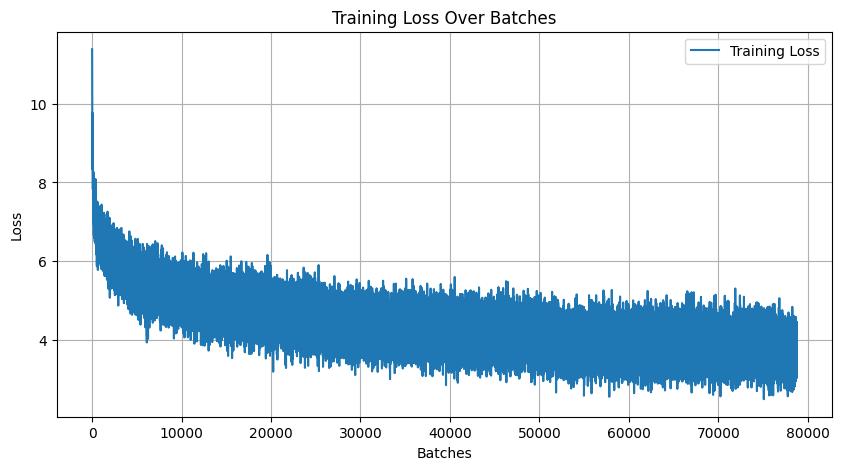

In [24]:
# Load the loss history from the .npy file
loss_history = np.load('loss_history.npy')

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [46]:
# Testing the model on a batch from the train loader (seen example)
test_batch = next(iter(train_loader))
input_ids = test_batch["input_ids"].to(device)
src_mask = test_batch["input_mask"].to(device)
target_ids = test_batch["target_ids"].to(device)
tgt_mask = test_batch["target_mask"].to(device)

print("Test input:\n",tokenizer.tokenizer.decode(input_ids[0], skip_special_tokens=True))
print("\nTest target:",tokenizer.tokenizer.decode(target_ids[0], skip_special_tokens=True))

model.eval()
with torch.no_grad():
    outputs = model.generate(input_ids, src_mask=src_mask, max_length=max_summary_length)

predicted_text = tokenizer.tokenizer.batch_decode(outputs, skip_special_tokens=True)  # Decode to text
print("Generated Output:", predicted_text[0])  # Print the predicted output

Test input:
 "The Security Council,
Recalling its resolution 1970 (2011) of 26 February 2011,
Deploring the failure of the Libyan authorities to comply with resolution 1970 (2011),
Expressing grave concern at the deteriorating situation, the escalation of violence, and the heavy civilian casualties,
Reiterating the responsibility of the Libyan authorities to protect the Libyan population and reaffirming that parties to armed conflicts bear the primary responsibility to take all feasible steps to ensure the protection of civilians,
Condemning the gross and systematic violation of human rights, including arbitrary detentions, enforced disappearances, torture and summary executions,
Further condemning acts of violence and intimidation committed by the Libyan authorities against journalists, media professionals and associated personnel and urging these authorities to comply with their obligations under international humanitarian law as outlined in resolution 1738 (2006),
Considering that t

In [42]:
# Testing the model on a batch from the test loader (unseen example)
test_batch = next(iter(test_loader))
input_ids = test_batch["input_ids"].to(device)
src_mask = test_batch["input_mask"].to(device)
target_ids = test_batch["target_ids"].to(device)
tgt_mask = test_batch["target_mask"].to(device)

print("Test input:\n",tokenizer.tokenizer.decode(input_ids[0], skip_special_tokens=True))
print("\nTest target:",tokenizer.tokenizer.decode(target_ids[0], skip_special_tokens=True))

model.eval()
with torch.no_grad():
    outputs = model.generate(input_ids, src_mask=src_mask, max_length=max_summary_length)

predicted_text = tokenizer.tokenizer.batch_decode(outputs, skip_special_tokens=True)  # Decode to text
print("Predicted Output:", predicted_text[0])  # Print the predicted output

Test input:
 Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the need f

In [37]:
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

test_loss = 0
all_references = []
all_hypotheses = []
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        # Move everything to device
        input_ids = batch["input_ids"].to(device)
        src_mask = batch["input_mask"].to(device)
        target_ids = batch["target_ids"].to(device)
        tgt_mask = batch["target_mask"].to(device)

        # Forward pass
        outputs = model(
            input_ids,
            target_ids,
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )

        # Calculate cross entropy loss directly
        loss = F.cross_entropy(
            outputs.view(-1, outputs.size(-1)),
            target_ids.view(-1),
            ignore_index=1
        )

        test_loss += loss.item()

        # Convert outputs and targets to strings for ROUGE score
        predictions = outputs.argmax(dim=-1).tolist()
        references = target_ids.tolist()
        
        for pred, ref in zip(predictions, references):
            pred_str = ' '.join(map(str, pred))
            ref_str = ' '.join(map(str, ref))
            
            # Calculate ROUGE scores for each prediction and reference
            score = scorer.score(ref_str, pred_str)
            
            rouge_scores['rouge1'].append(score['rouge1'])
            rouge_scores['rouge2'].append(score['rouge2'])
            rouge_scores['rougeL'].append(score['rougeL'])

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Calculate average ROUGE scores
avg_rouge1 = sum([score.fmeasure for score in rouge_scores['rouge1']]) / len(rouge_scores['rouge1'])
avg_rouge2 = sum([score.fmeasure for score in rouge_scores['rouge2']]) / len(rouge_scores['rouge2'])
avg_rougeL = sum([score.fmeasure for score in rouge_scores['rougeL']]) / len(rouge_scores['rougeL'])

print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"ROUGE-L Score: {avg_rougeL:.4f}")

Test Loss: 11.3033
ROUGE-1 Score: 0.0842
ROUGE-2 Score: 0.0264
ROUGE-L Score: 0.0697


In [38]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params}")

Total number of parameters: 53374809
